## Experiment 3: Quark Gluon
- 20000 samples
- Train pairs: (36000, 2, 40, 40)
- Test pairs:  (4000, 2, 40, 40)
- using only 1 channel, 2nd channel
- Data: cropping, normalisation, pair creation
- Model: Base CNN + Qnn layers
- Loss: contrastive margin pair loss
- Siamese Network
- Training epochs 20, batch size 128, loss: 0.2 approx

### Imports and Data loading

In [1]:
# Required imports
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, initializers

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix as cmatrix

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
d = np.load('../../data/quark_gluon_dataset/quark_gluon_20000_1.npz', allow_pickle=True)
x_train = d["x_train"]
y_train = d["y_train"]
x_test = d["x_test"]
y_test = d["y_test"]

In [3]:
import matplotlib.pyplot as plt

def plot_image_grid(data, label, filter_label=None, channel=0, rows=5, cols=5):
    # Filter the data and labels if filter_label is provided
    if filter_label is not None:
        indices = [i for i, l in enumerate(label) if l == filter_label]
        filtered_data = data[indices]
        filtered_label = label[indices]
    else:
        filtered_data = data
        filtered_label = label

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(filtered_data):
                axes[i, j].imshow(filtered_data[idx,:,:,channel])
                axes[i, j].title.set_text(f'{filtered_label[idx]}')
            axes[i, j].axis('off')

    plt.show()

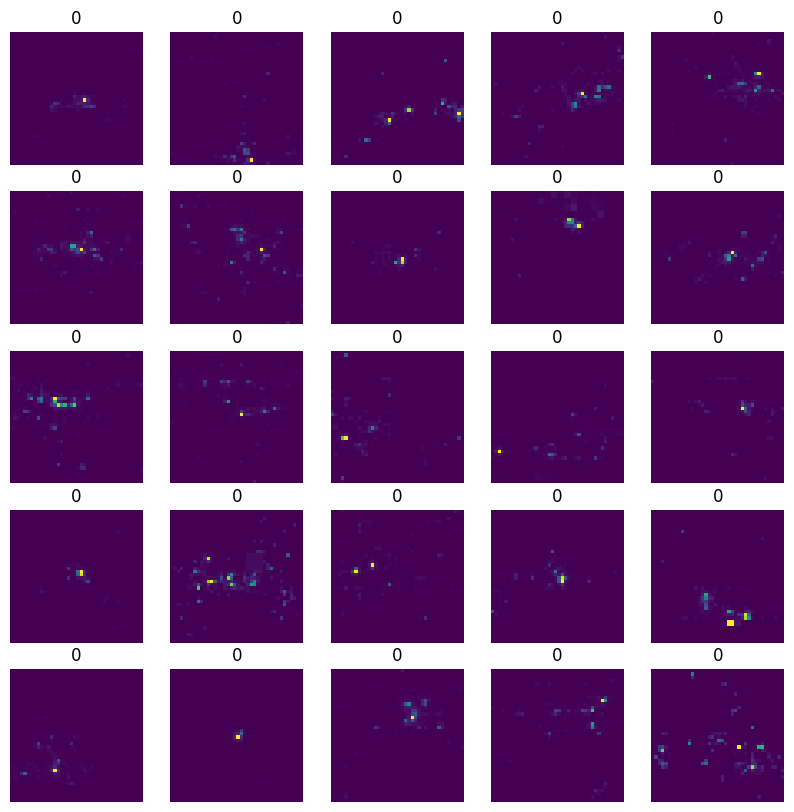

In [4]:
plot_image_grid(x_train, y_train, filter_label=0,channel=1)

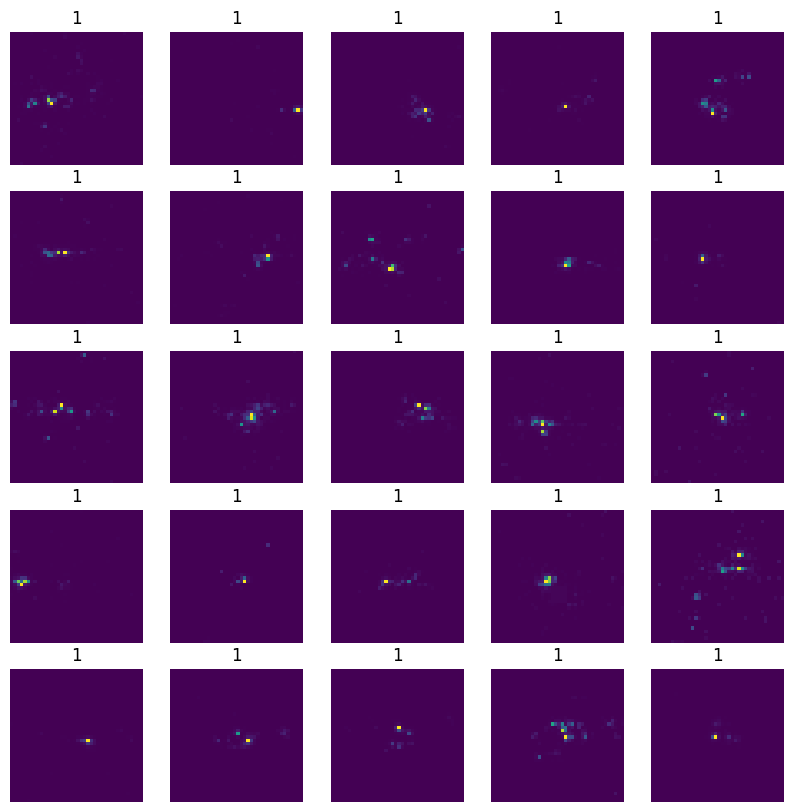

In [5]:
plot_image_grid(x_train, y_train, filter_label=1,channel=1)

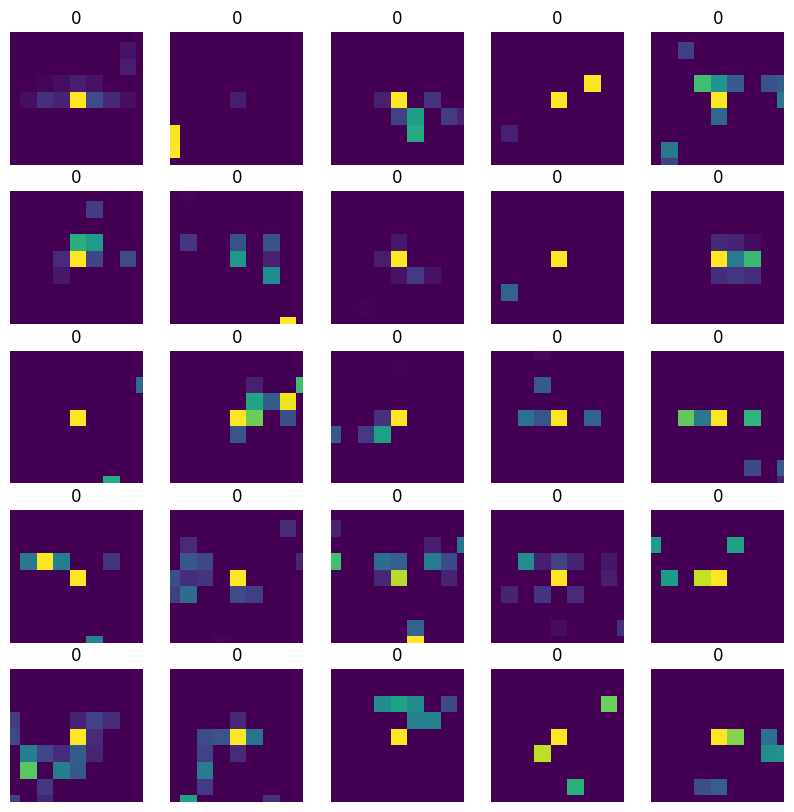

In [6]:
plot_image_grid(x_train, y_train, filter_label=0,channel=2)

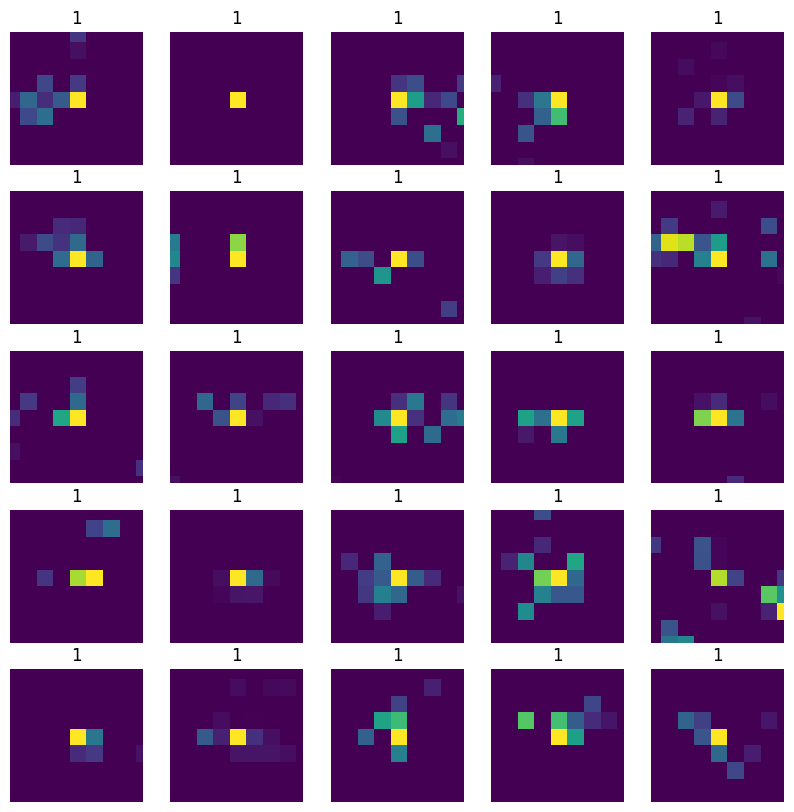

In [7]:
plot_image_grid(x_train, y_train, filter_label=1,channel=2)

In [8]:
data = np.load('../../data/quark_gluon_dataset/qg_20000_pairs_c2.npz', allow_pickle=True)

pairs_train = data["pairs_train"]
labels_train = data["labels_train"]
pairs_test = data["pairs_test"]
labels_test = data["labels_test"]

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape, labels_test.shape)

(36000, 2, 40, 40) (4000, 2, 40, 40)
(36000,) (4000,)


In [9]:
pairs_train = np.expand_dims(pairs_train, -1)
pairs_test = np.expand_dims(pairs_test, -1)
print(pairs_train.shape)

(36000, 2, 40, 40, 1)


In [10]:
def plot_sample_pairs(pairs, labels, shape, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(pairs[i, 0].reshape(shape, shape))
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(pairs[i, 1].reshape(shape, shape))
        ax.axis('off')

        label = labels[i]
        plt.title(f'Sample: {i}, Label: {label}')

    plt.tight_layout()
    plt.show()

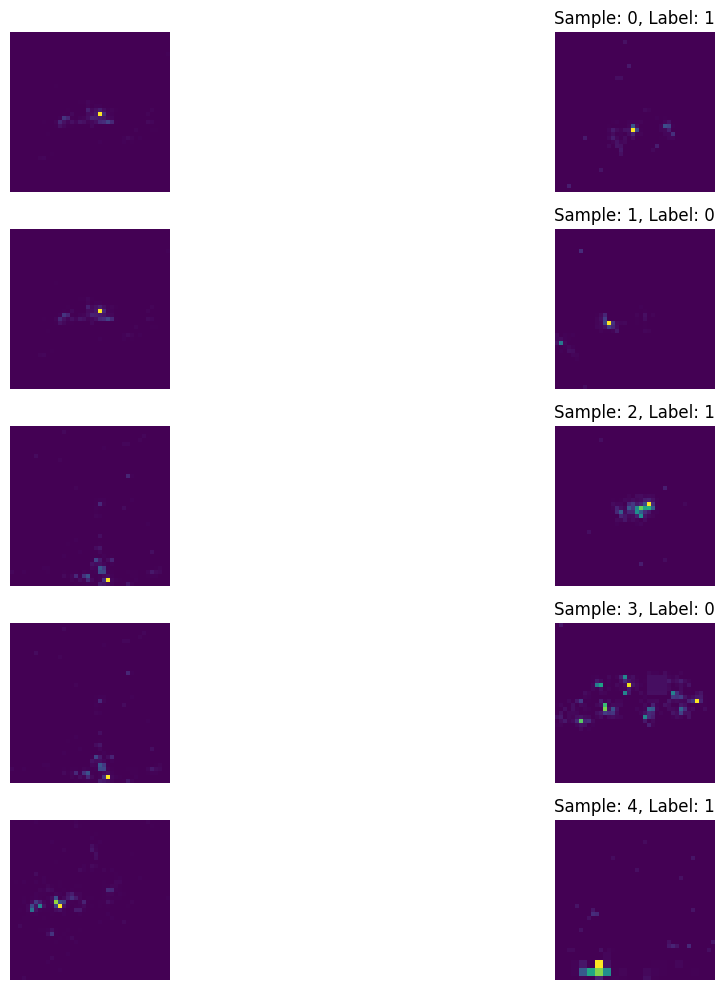

In [11]:
plot_sample_pairs(pairs_train, labels_train, shape=40, num_samples=5)

### Quantum Layer

In [12]:
# Defining quantum circuit for quantum layer
n_qubits = 8
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

(<Figure size 500x900 with 1 Axes>, <Axes: >)

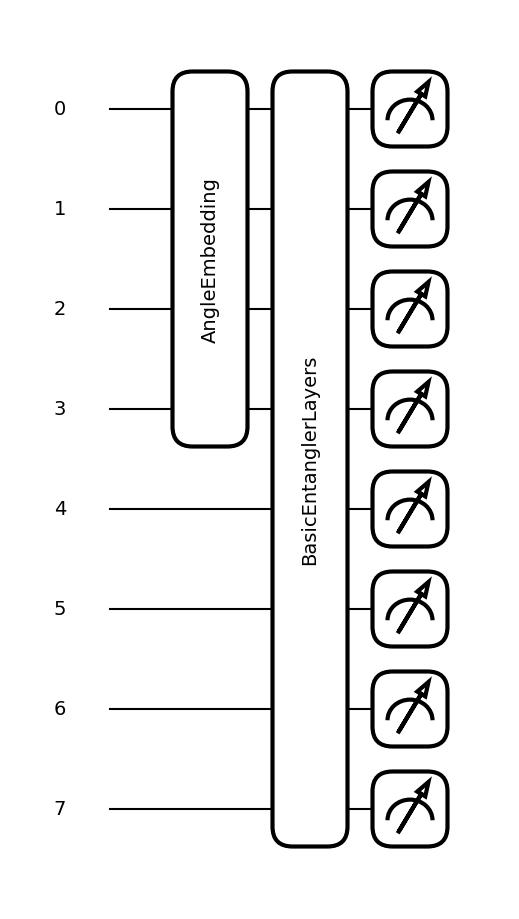

In [13]:
# Plotting a sample circuit with random weights for visualization
weights = np.random.random((n_layers, n_qubits))
X=[1,2,3,4]
qml.draw_mpl(quantum_circuit)(X,weights)

### Model

In [14]:
# Define trainable weights for the quantum circuit (will be used in training)
weight_shapes = {"weights": (n_layers, n_qubits)}
quantum_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

# Base model from classical nb, adding qlayer in between
def create_quantum_cnn(input_shape, return_embeddings=False):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu')) # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Conv layer 2
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # ------ Quantum layer added in nb 2 classical base architecture
    # Reducing dimensions to match n_qubits
    model.add(layers.Dense(n_qubits)) 
    # Quantum layer
    model.add(quantum_layer)
    # Dense layer after quantum layer
    model.add(layers.Dense(n_qubits, activation='relu'))
    if return_embeddings:
        return model
    # --------------------------------------------------------------
    
    # model.add(layers.Dense(1, activation='sigmoid'))  
    return model

# Contrastive Pair loss
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_quantum_cnn(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])


    siamese_model = models.Model([input_0, input_1], distance)

    return siamese_model, base_model

### Training

In [15]:
# Training
tf.get_logger().setLevel('ERROR')

# checkpoint_path = "hybrid_cnn_base_1_ep/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='hybrid_model_qg1_c2.h5', save_weights_only=True,verbose=1)


input_shape = pairs_train.shape[2:]
siamese_network, base_model = create_siamese_network(input_shape)

siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam(learning_rate=1e-3))

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=20,
    batch_size=128,
    callbacks=[cp_callback]
)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.2808
Epoch 1: saving model to hybrid_model_qg1_c2.h5
282/282 [==============================] - 1229s 4s/step - loss: 0.2808 - val_loss: 0.2652
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.2661
Epoch 2: saving model to hybrid_model_qg1_c2.h5
282/282 [==============================] - 1150s 4s/step - loss: 0.2661 - val_loss: 0.2640
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.2635
Epoch 3: saving model to hybrid_model_qg1_c2.h5
282/282 [==============================] - 1025s 4s/step - loss: 0.2635 - val_loss: 0.2604
Epoch 4/20
282/282 [==============================] - ETA: 0s - loss: 0.2607
Epoch 4: saving model to hybrid_model_qg1_c2.h5
282/282 [==============================] - 628s 2s/step - loss: 0.2607 - val_loss: 0.2618
Epoch 5/20
282/282 [==============================] - ETA: 0s - loss: 0.2586
Epoch 5: saving model to hybrid_model_qg1_c2.h5
282/282 [===

In [16]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 8)                    1203240   ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['sequential[0][0]',      

<Axes: title={'center': 'Learning History'}>

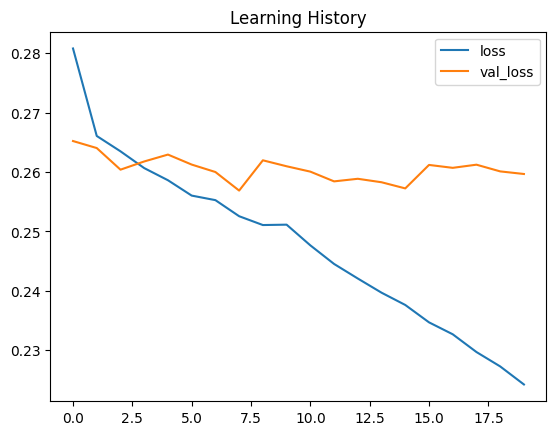

In [17]:
pd.DataFrame(history.history).plot(title="Learning History")

### Embeddings

In [18]:
embedding_model = models.Model(inputs=base_model.input, outputs=base_model.output)

# Use the model to predict (get embeddings) for new data
embeddings = embedding_model.predict(x_test[:,:,:,0])

# Example: fetching embeddings for the training data
print(embeddings.shape)

63/63 [==============================] - 25s 396ms/step
(2000, 8)


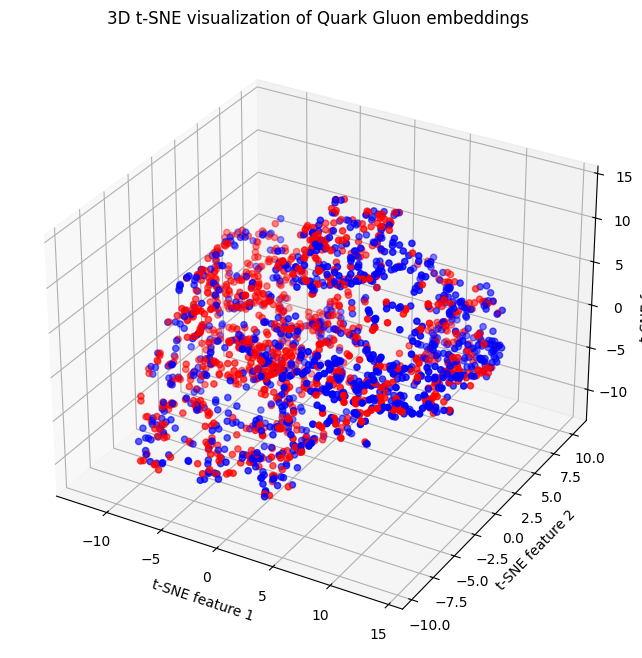

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

df = pd.DataFrame(embeddings_3d, columns=['tsne1', 'tsne2', 'tsne3'])
df['label'] = y_test

# Visualize the 3D embeddings
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['red' if label == 1 else 'blue' for label in y_test]
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors)
ax.set_title('3D t-SNE visualization of Quark Gluon embeddings')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
plt.show()

### Model Evaluation

In [20]:
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

y_pred = distances_to_labels(distance)

125/125 [==============================] - 103s 823ms/step


In [21]:
from helpers import evaluate_precision_recall_accuracy
evaluate_precision_recall_accuracy(labels_test,y_pred)

(0.539553752535497, 0.532, 0.539)

In [22]:
from helpers import plot_auc

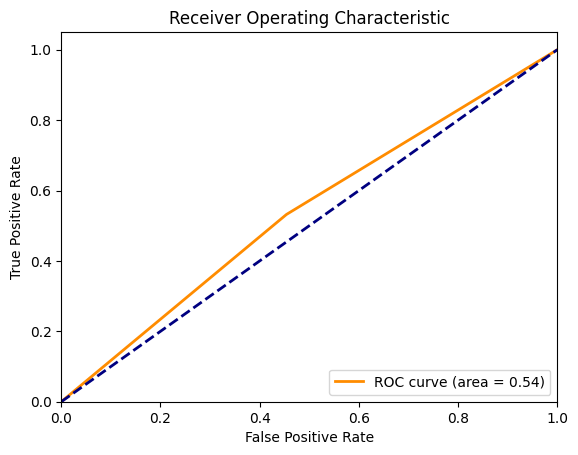

In [23]:
plot_auc(labels_test,y_pred)